#### **Import the required libraries**

We will be using a few libraries in this session, import all the required libraries in the cell below one by one as we go through the session.


In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

#### **Download the dataset**

We will be using `CIFAR-10` dataset for this session. The dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Please download the dataset using the following command.

```python
!wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CIFAR-10.zip
!wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/linear_config.yaml
!unzip -q CIFAR-10.zip -d .
```


In [26]:
# Check before downloading CIFAR-10.zip
if not os.path.exists('CIFAR-10.zip'):
    !wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/CIFAR-10.zip
else:
    print("CIFAR-10.zip already exists. Skipping download.")

# Check before downloading linear_config.yaml
if not os.path.exists('linear_config.yaml'):
    !wget https://github.com/jahirsadik/cail-workshop-session-1/raw/main/linear_config.yaml
else:
    print("linear_config.yaml already exists. Skipping download.")

# Check before unzipping CIFAR-10.zip
if os.path.exists('CIFAR-10.zip') and not os.path.exists('CIFAR-10'):
    !unzip -q CIFAR-10.zip -d .
else:
    print("CIFAR-10 directory already exists or zip file is missing. Skipping unzip.")

CIFAR-10.zip already exists. Skipping download.
linear_config.yaml already exists. Skipping download.
CIFAR-10 directory already exists or zip file is missing. Skipping unzip.


#### **Load configuration file**

We will be using a configuration file to store all the required parameters for the model. The configuration file is a YAML file, which is a human-readable data serialization standard that can be used in conjunction with all programming languages and is often used to write configuration files. Create a new file named `config.yaml` and add the following content to it.

```yaml
data_params:
  data_path: "CIFAR-10/"
```

Read the configuration file using the `yaml` library and store the data in a variable named `config`.


In [3]:
file = open("linear_config.yaml")
config = yaml.safe_load(file)
file.close()
print(config)

{'data_params': {'data_path': 'CIFAR-10/', 'train_ratio': 0.8}, 'model_params': {'lr': 0.001, 'epochs': 50, 'batch_size': 64, 'seed': 42}}


#### **Load the dataset**

Check the files in the side panel to see if the dataset is downloaded successfully. The dataset is organized in the following way.

```
CIFAR-10
 |
 └───airplane
 |
 └───automobile
 |
 └───bird
 |
 └───cat
 |
 └───deer
 |
 └───dog
 |
 └───frog
 |
 └───horse
 |
 └───ship
 |
 └───truck
```

We will use basic python libraries like `os` and `numpy` to load the dataset. Create a function `load_data` to load the dataset. The function should take the path to the dataset as input and return a numpy array of images and labels. Following is the pseudo code for the function:

```python
def load_data(path, classes):
    # create empty lists to store images and labels

    # loop through the classes
        # create path to the class folder
        # loop through the images in the class folder
            # create the path to the image
            # read the image using PIL
            # convert the image to numpy array
            # append the image to the images list
            # append the class index to the labels list

    # return the images and labels as numpy arrays
```


In [4]:
def load_data(path: str, classes: list) -> tuple:
    """
    Load data from the given path and return the data and labels as numpy arrays.

    :param path: The path to the data.
    :type path: str
    :param classes: The classes in the data.
    :type classes: list

    :return: The data and labels.
    :rtype: tuple(np.array, np.array)
    """

    images = []
    labels = []
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            img = np.array(img)
            images.append(img)
            labels.append(i)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

As the subfolder names are the class names, get the class names using `os.listdir` and save it to a variable `classes`. Use the `load_data` function to load the dataset and save the images and labels to variables `images` and `labels` respectively.


In [5]:
data_path = config["data_params"]["data_path"]
classes = os.listdir(data_path)
classes.sort()
print(classes)

images, labels = load_data(data_path, classes)
print(images.shape, labels.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(60000, 32, 32, 3) (60000,)


#### **Visualize the data**

Now, our dataset is loaded. Let's visualize the dataset using `matplotlib`. Choose a random image from the dataset and display the image along with the class name as the title. **Note:** In each run, the image should change, you can use `np.random.randint` to generate a random index.


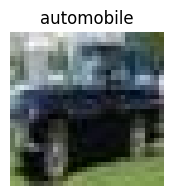

In [6]:
random_index = np.random.randint(0, len(images))

plt.figure(figsize=(2, 2))
plt.imshow(images[random_index])
plt.title(classes[labels[random_index]])
plt.axis('off')
plt.show()

#### **Preprocess the data**

We need to normalize the images before feeding them to the model. Normalization is a process that changes the range of pixel intensity values to a standard range, it helps the model to converge faster. To normalize the images, we will use the following steps:

1. Normalize to [0-1] by dividing each pixel by 255.
2. Subtract the ImageNet mean (0.485, 0.456, 0.406) and divide by the ImageNet standard deviation (0.229, 0.224, 0.225).

After normalization, we need to flatten the images. Use `np.reshape` to flatten the images.

Create a function `preprocess_data` to do the above steps. The function should take the images input and return the preprocessed images. Following is the pseudo code for the function:

```python
def preprocess_data(images):
    # normalize the images using ImageNet mean and standard deviation
    # flatten the images
    # return the preprocessed images
```


In [7]:
def preprocess_images(images: np.array, labels: np.array) -> tuple:
    """
    Preprocess the images and labels.

    :param images: The images.
    :type images: np.array
    :param labels: The labels.
    :type labels: np.array

    :return: The preprocessed images and labels.
    :rtype: tuple(np.array, np.array)
    """
    images = images / 255.0
    images = (images - np.array([0.485, 0.456, 0.406])
              ) / np.array([0.229, 0.224, 0.225])
    images = images.reshape(-1, 32*32*3)

    labels = np.eye(len(np.unique(labels)))[labels]

    return images, labels

Call the `preprocess_data` function to preprocess the images and save the preprocessed images to a variable `images`.


In [8]:
images, labels = preprocess_images(images, labels)
print(images.shape, labels.shape)

(60000, 3072) (60000, 10)


#### **Split the data**

We need to split the data into training, testing, and validation sets. We will use `train_test_split` from `sklearn.model_selection` to split the data into training and testing sets. We will use 80% of the data for training and 20% for testing. Then, we will use `train_test_split` again to split the testing data into testing and validation sets. We will use 50% of the testing data for testing and 50% for validation.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=(1-config["data_params"]["train_ratio"]),
    random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48000, 3072) (6000, 3072) (6000, 3072)
(48000, 10) (6000, 10) (6000, 10)


#### **Linear Classifier Model**

We will use a simple linear classifier model for this session.

$$f(x, W, b) = Wx + b$$

Where:

- $x$ is the input image
- $W$ is the weight matrix
- $b$ is the bias vector

The size of the weight matrix $W$ is $(32*32*3, 10)$ and the size of the bias vector $b$ is $(10,)$. Follow the below steps to create the model:


##### **Step 1: Initialize the weights and bias**

Write a function named `random_init` to initialize the weights and bias. The function should take number of input features and number of output classes as input and return the weights and bias. Use `np.random.randn` to initialize the weights and bias.


In [10]:
def random_init(num_features: int, num_classes: int, seed: int = 42) -> tuple:
    """
    Initialize the weights and bias for the model.

    :param num_features: The number of features.
    :type num_features: int
    :param num_classes: The number of classes.
    :type num_classes: int
    :param seed: The random seed.
    :type seed: int

    :return: The weights and bias.
    :rtype: tuple(np.array, np.array)
    """
    np.random.seed(seed)
    W = np.random.randn(num_features, num_classes) * 1e-5
    b = np.random.randn(num_classes) * 1e-3
    return W, b

##### **Step 2: Softmax function & derivative**

Write two functions named `softmax` and `softmax_derivative` to calculate the softmax and its derivative. The softmax function is given by:

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

Where:

- $x_i$ is the input to the softmax function
- $x_j$ is the output of the softmax function


In [11]:
def softmax(logits: np.array) -> np.array:
    """
    Compute the softmax of the logits.

    :param logits: The logits.
    :type logits: np.array

    :return: The softmax of the logits.
    :rtype: np.array
    """
    max_logits = np.max(logits, axis=-1, keepdims=True)
    exp_logits = np.exp(logits - max_logits)
    sum_exp_logits = np.sum(exp_logits, axis=-1, keepdims=True)
    softmax = exp_logits / sum_exp_logits
    return softmax


def derivative_softmax(logits: np.array, y: np.array) -> np.array:
    """
    Compute the derivative of the softmax.

    :param logits: The logits.
    :type logits: np.array
    :param y: The labels.
    :type y: np.array

    :return: The derivative of the softmax.
    :rtype: np.array
    """
    return softmax(logits) * (1 - softmax(logits))

##### **Step 3: Forward pass**

Write a function named `forward` to perform the forward pass. The function should take input images, weights, and bias as input and return the logits. The logits can be calculated using the formula $f(x, W, b) = Wx + b$. The function should also return the sigmoid of the logits.


In [12]:
def forward(X: np.array, W: np.array, b: np.array) -> np.array:
    """
    Perform the forward pass.

    :param X: The input data.
    :type X: np.array
    :param W: The weights.
    :type W: np.array
    :param b: The bias.
    :type b: np.array

    :return: The predictions.
    :rtype: np.array
    """
    return softmax(np.dot(X, W) + b)

##### **Step 4: Loss function**

We will use the cross-entropy loss function for this model. The cross-entropy loss function is given by:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(\hat{y}_i)$$

Where:

- $y$ is the true label
- $\hat{y}$ is the predicted label
- $N$ is the number of samples

Write a function named `cross_entropy_loss` to calculate the cross-entropy loss. The function should take true labels and predicted labels as input and return the loss.


In [13]:
def cross_entropy_loss(y: np.array, y_pred: np.array) -> float:
    """
    Calculate the cross-entropy loss.

    :param y: The true labels.
    :type y: np.array
    :param y_pred: The predicted labels.
    :type y_pred: np.array

    :return: The loss.
    :rtype: float
    """
    # Clip the predictions to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    return -np.sum(y * np.log(y_pred)) / y.shape[0]

##### **Step 5: Backward pass**

Write a function named `backward` to perform the backward pass. The function should take input images, true labels, weights, bias, and softmax logits as input and return the gradients of weights and bias. The gradients can be calculated using the following formulas:

$$\frac{\partial L}{\partial W} = \frac{1}{N} X^T \cdot (\hat{y} - y)$$

$$\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y} - y)$$

Where:

- $X$ is the input images
- $y$ is the true label
- $\hat{y}$ is the predicted label
- $N$ is the number of samples


In [14]:
def backward(
    X: np.array,
    y: np.array,
    y_pred: np.array,
) -> tuple:
    """
    Perform the backward pass.

    :param X: The input data.
    :type X: np.array
    :param y: The true labels.
    :type y: np.array
    :param y_pred: The predicted labels.
    :type y_pred: np.array

    :return: The gradients.
    :rtype: tuple(np.array, np.array)
    """
    m = X.shape[0]
    dW = (1 / m) * np.dot(X.T, (y_pred - y))
    db = (1 / m) * np.sum((y_pred - y), axis=0)
    return dW, db

##### **Step 6: Update weights and bias**

Write a function named `update` to update the weights and bias. The function should take learning rate, weights, bias, gradients of weights, and gradients of bias as input and return the updated weights and bias. The weights and bias can be updated using the formula:

$$W = W - \alpha \cdot \frac{\partial L}{\partial W}$$

$$b = b - \alpha \cdot \frac{\partial L}{\partial b}$$

Where:

- $\alpha$ is the learning rate


In [15]:
def update(
    W: np.array,
    b: np.array,
    dW: np.array,
    db: np.array,
    lr: float
) -> tuple:
    """
    Update the weights and bias.

    :param W: The weights.
    :type W: np.array
    :param b: The bias.
    :type b: np.array
    :param dW: The weights gradients.
    :type dW: np.array
    :param db: The bias gradients.
    :type db: np.array
    :param lr: The learning rate.
    :type lr: float

    :return: The updated weights and bias.
    :rtype: tuple(np.array, np.array)
    """
    W -= lr * dW
    b -= lr * db
    return W, b

##### **Step 7: Validate or test the model**

Write a function named `validate` to validate or test the model. The function should take input images, weights, and bias as input and return the loss, y_pred of the model.


In [16]:
def validate(
    X: np.array,
    y: np.array,
    W: np.array,
    b: np.array,
    batch_size: int
) -> tuple:
    """
    Validate the model.

    :param X: The input data.
    :type X: np.array
    :param y: The true labels.
    :type y: np.array
    :param W: The weights.
    :type W: np.array
    :param b: The bias.
    :type b: np.array
    :param batch_size: The batch size.
    :type batch_size: int

    :return: The loss and the predicted labels.
    :rtype: tuple(float, np.array)
    """
    loss_val = 0
    predictions = []
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        y_pred = forward(X_batch, W, b)
        loss_ = cross_entropy_loss(y_batch, y_pred)
        loss_val += loss_
        predictions.append(y_pred)
    loss_val /= X.shape[0]
    y_pred = np.concatenate(predictions, axis=0)

    return loss_val, y_pred

#### **Step 8: Train the model**

Now, we have all the required functions to train the model. We will use the following steps to train the model:

1. Initialize the weights and bias
2. Forward pass
3. Calculate the loss
4. Backward pass
5. Update weights and bias
6. Validate the model
7. Repeat the steps 2-6 for a number of epochs


In [17]:
def train(
    X: np.array,
    y: np.array,
    num_classes: int,
    num_epoch: int,
    lr: float,
    batch_size: int,
    seed: int = 42
) -> tuple:
    """
    Train the model.

    :param X: The input data.
    :type X: np.array
    :param y: The true labels.
    :type y: np.array
    :param num_classes: The number of classes.
    :type num_classes: int
    :param num_epoch: The number of epochs.
    :type num_epoch: int
    :param lr: The learning rate.
    :type lr: float
    :param batch_size: The batch size.
    :type batch_size: int
    :param seed: The random seed.
    :type seed: int

    :return: The weights and bias.
    :rtype: tuple(np.array, np.array)
    """
    num_samples, num_features = X.shape
    W, b = random_init(num_features, num_classes, seed)
    loss = {
        "train": [],
        "val": []
    }

    for i in range(num_epoch):
        loss_epoch = 0

        loop = tqdm.tqdm(
            range(0, num_samples, batch_size), leave=False, ncols=100)
        for j in loop:
            X_batch = X[j:j+batch_size]
            y_batch = y[j:j+batch_size]

            # Forward pass
            y_pred = forward(X_batch, W, b)

            # Calculate loss
            loss_ = cross_entropy_loss(
                y_batch, y_pred)
            loss_epoch += loss_

            # Backward pass
            dW, db = backward(X_batch, y_batch, y_pred)

            # Update weights and bias
            W, b = update(W, b, dW, db, lr)

            loop.set_description(f"Epoch [{i+1}/{num_epoch}]")
            loop.set_postfix(loss=loss_)

        loss["train"].append(loss_epoch/num_samples)

        # Validate
        loss_val, y_pred = validate(X, y, W, b, batch_size)
        loss["val"].append(loss_val)

    return W, b, loss

##### **Train the model**

Call the `train` function to train the model and plot the training loss and validation loss.


In [18]:
weights, bias, loss = train(
    X_train,
    y_train,
    len(classes),
    6,# config["model_params"]["epochs"], #50
    0.1, # config["model_params"]["lr"], #0.01
    64, # config["model_params"]["batch_size"], #64
    config["model_params"]["seed"] #42
)

#### **Plot the learning curve**

Plot the training loss and validation loss using `matplotlib`, keep both the training loss and validation loss in the same plot.


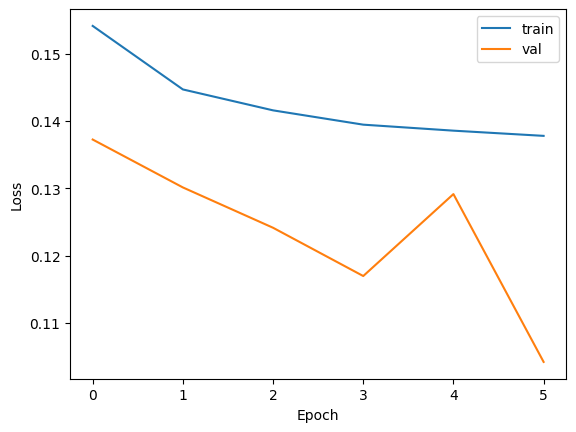

In [19]:
plt.plot(loss["train"], label="train")
plt.plot(loss["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **Evaluate model performance**

Now, we have trained the model. Call the `validate` function to validate the model and calculate the loss and predicted labels on the testing data.

1. Use scikit-learn's `classification_report` function to evaluate the performance of the model. The `classification_report` function takes two inputs, `test_labels` and `predicted_labels`, and returns a report of the precision, recall, and F1-score of the model.
2. Use the `confusion_matrix` function to get the confusion matrix of the model. It also takes two inputs, `test_labels` and `predicted_labels`, and returns the confusion matrix of the model. Use `ConfusionMatrixDisplay` to display the confusion matrix.


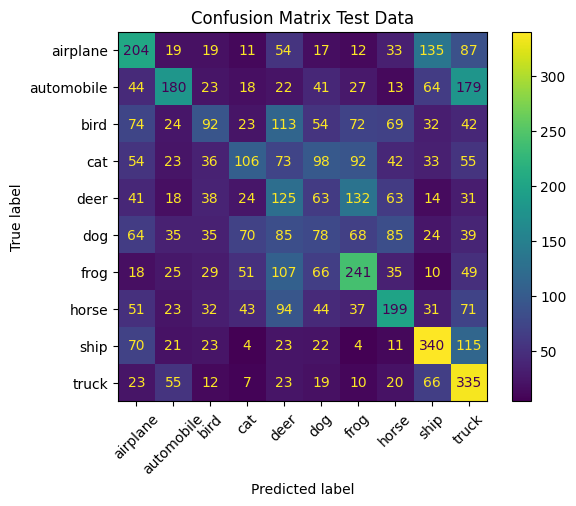




              precision    recall  f1-score   support

    airplane       0.32      0.35      0.33       591
  automobile       0.43      0.29      0.35       611
        bird       0.27      0.15      0.20       595
         cat       0.30      0.17      0.22       612
        deer       0.17      0.23      0.20       549
         dog       0.16      0.13      0.14       583
        frog       0.35      0.38      0.36       631
       horse       0.35      0.32      0.33       625
        ship       0.45      0.54      0.49       633
       truck       0.33      0.59      0.43       570

    accuracy                           0.32      6000
   macro avg       0.31      0.32      0.31      6000
weighted avg       0.32      0.32      0.31      6000



In [20]:
# bottom level to a slight tilted

_, y_pred = validate(X_test, y_test, weights, bias,
                     config["model_params"]["batch_size"])

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))

#### **Visualize the weights**

We can visualize the weights of the model to see what the model has learned. Use `plt.imshow` to visualize the weights of the model.


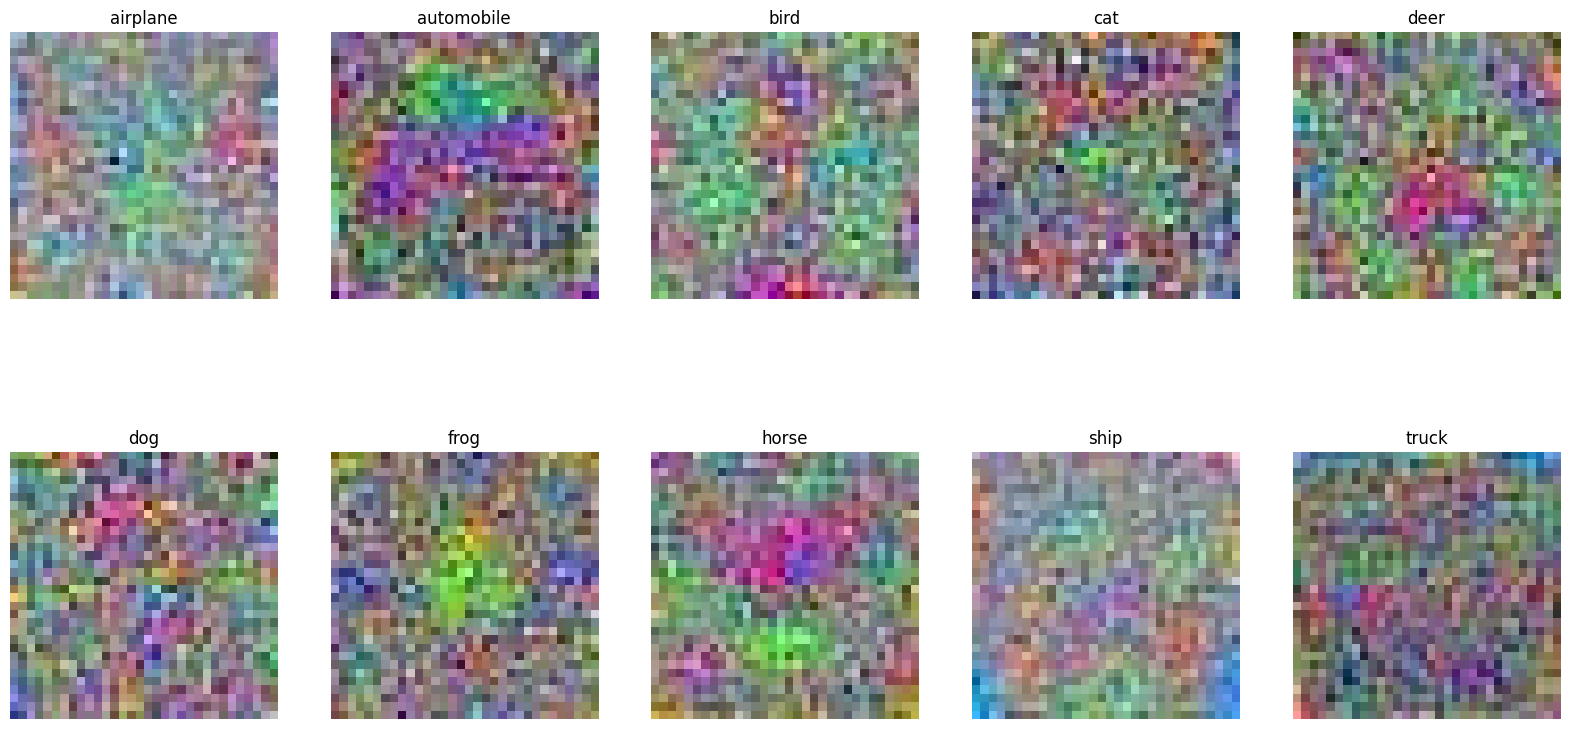

In [21]:
fig, axes = plt.subplots(2, len(classes)//2, figsize=(20, 10))
for i, class_name in enumerate(classes):
    row, col = i // 5, i % 5
    img = weights[:, i].reshape(32, 32, 3)
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype("uint8")
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')
plt.show()